# 08/04

# PK/PD AL Model Calibration

## Checking model status/efficacy after changing patient blood volume calculation

### From ```patient_blood_volume = weight * (70.0 * 1000)``` to ```patient_blood_volume = (weight)^0.25 * (70.0 * 1000)```

<br>

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

In [2]:
# Define the range for weight_art
min_weight = 1
max_weight = 100

# Define weight_art values
weight_values = np.linspace(min_weight, max_weight, 100) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(weight_values))
failed_treatment_count_values = np.zeros(len(weight_values))

print(weight_values)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100.]


In [3]:
def run_simulation_art_weight_adj(idx, weight, n_patients):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame(
            [line.split() for line in lines_weight],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[df_weight['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_weight)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [4]:
test_exponent = 0.5  # Exponent for patient blood volume calculation
file_suffix = f"patient_blood_volume_exponent_{test_exponent}"

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 500  # Number of patients for each simulation

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i], n_patients) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_art_weight_adj, params_list):
            idx, efficacy, df_weight = result
            results.append((idx, efficacy, df_weight))
            if df_weight is not None:
                dfs.append(df_weight)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_weight in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with weight_values and clearance_rates
df = pd.DataFrame({
    'Weight': weight_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_weight_vs_efficacy_results_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_weight_vs_efficacy_results_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_weight_vs_efficacy_results_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 100/100 [02:31<00:00,  1.52s/it] 

DataFrame saved as pickle and CSV files successfully.


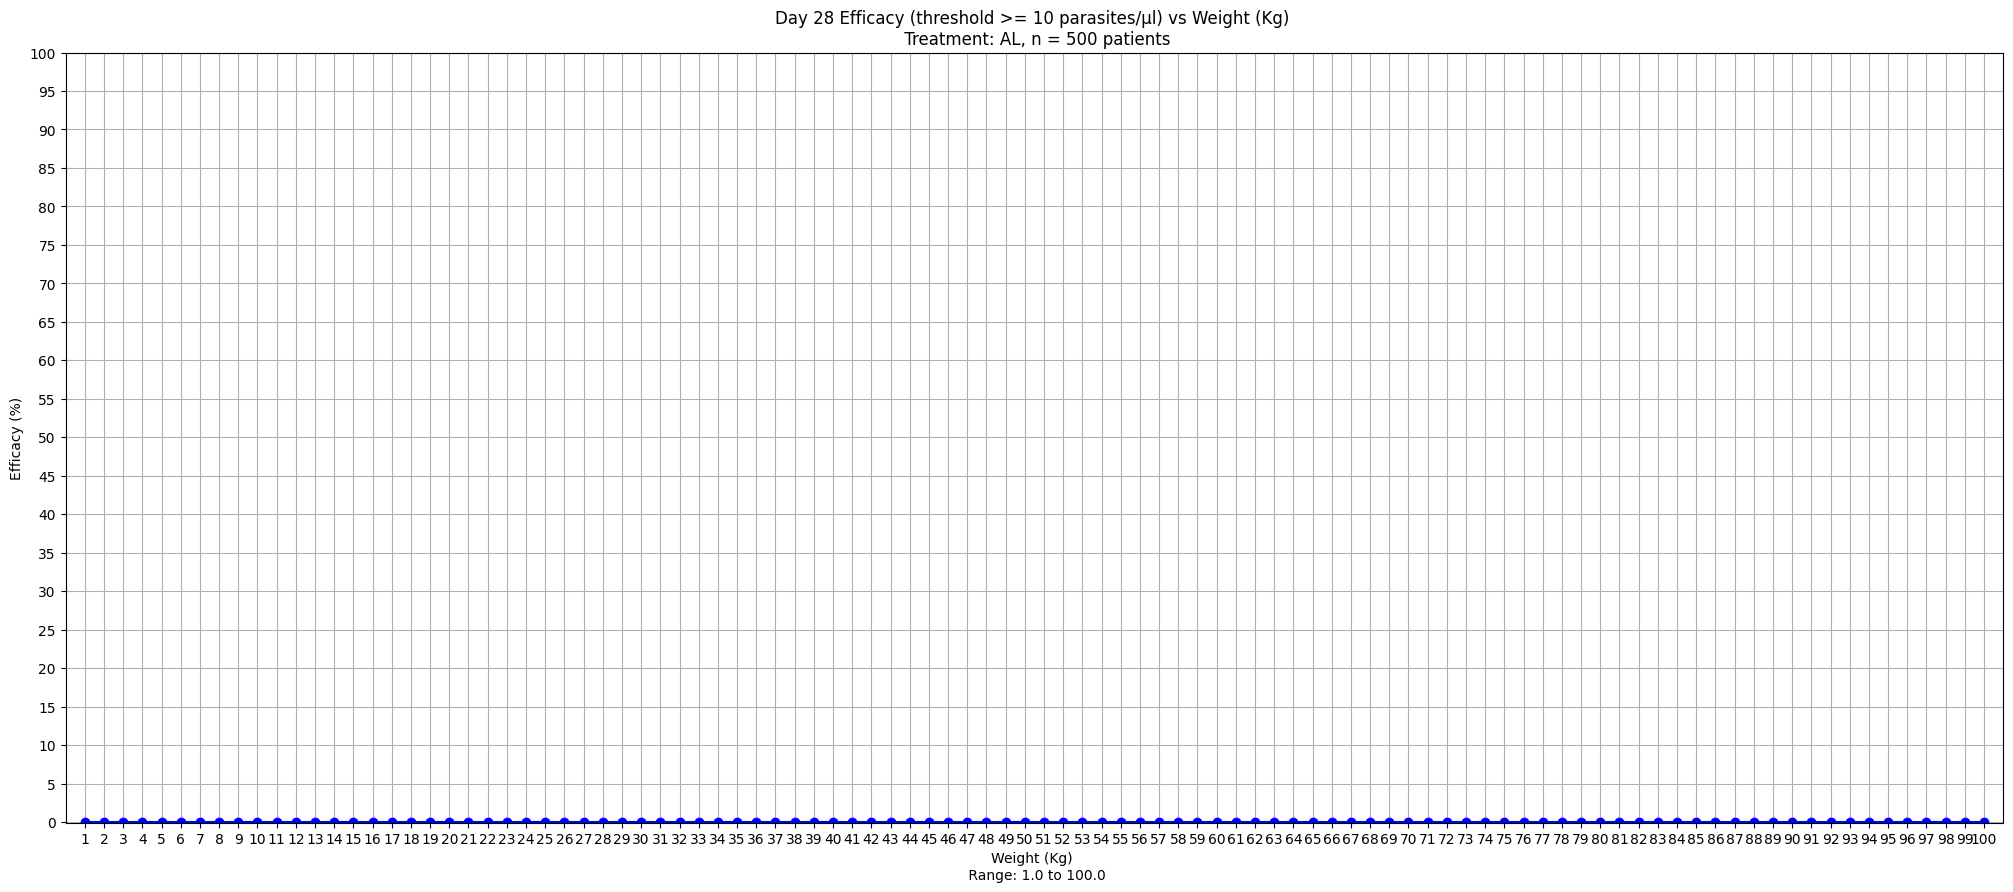

In [5]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'Weight (Kg) \n Range: {min(weight_values)} to {max(weight_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs Weight (Kg) \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(0, max(weight_values)+1)  # Set x-axis limits
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 1))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
#plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_weight_vs_efficacy_results_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

<br>

---

# Editing ```pmax_artemether``` and ```ec50_lum``` values to check if it improves efficacy

In [6]:
def run_simulation_art_weight_adj(idx, weight, n_patients):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--pmax_artemether", "0.9998653531",
        "--ec50_lum", "72.789",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame(
            [line.split() for line in lines_weight],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[df_weight['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_weight)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [7]:
test_exponent = 0.5  # Exponent for patient blood volume calculation
file_suffix = f"patient_blood_volume_exponent_{test_exponent}_adjusted_pmax_ec50"

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 500  # Number of patients for each simulation

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i], n_patients) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_art_weight_adj, params_list):
            idx, efficacy, df_weight = result
            results.append((idx, efficacy, df_weight))
            if df_weight is not None:
                dfs.append(df_weight)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_weight in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with weight_values and clearance_rates
df = pd.DataFrame({
    'Weight': weight_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"pkpd_AL_weight_vs_efficacy_results_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"pkpd_AL_weight_vs_efficacy_results_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"pkpd_AL_weight_vs_efficacy_results_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 100/100 [02:29<00:00,  1.49s/it] 

DataFrame saved as pickle and CSV files successfully.


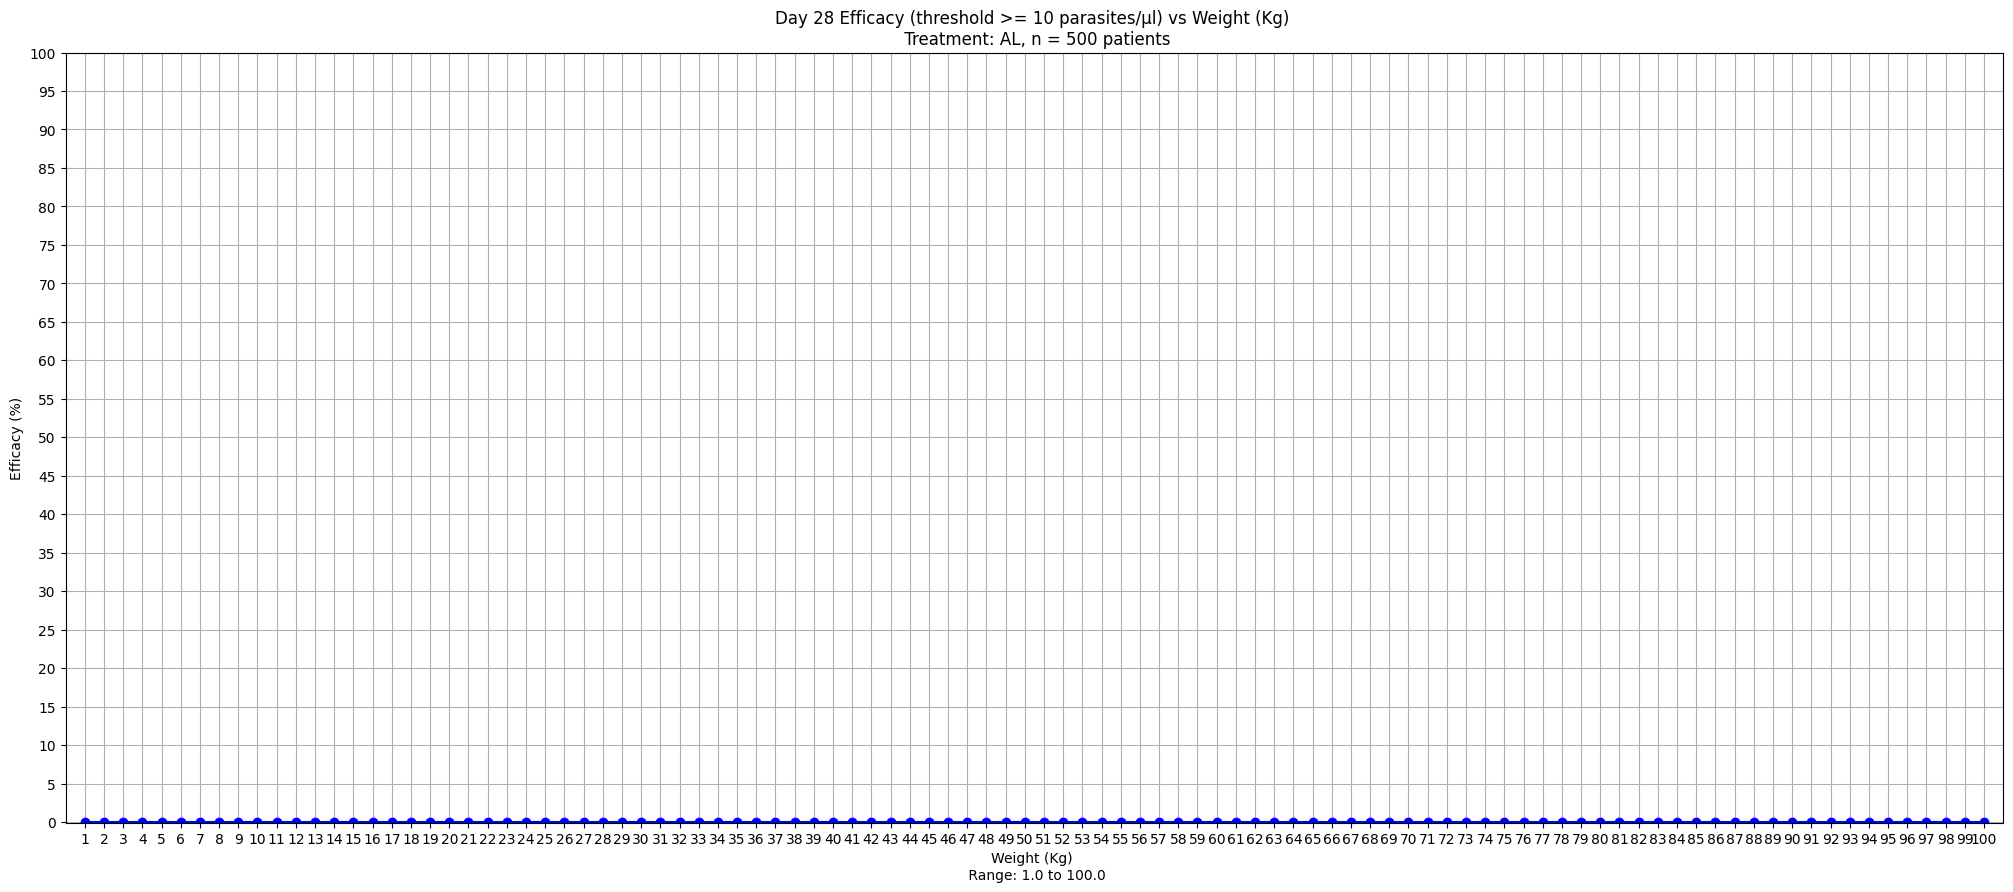

In [8]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'Weight (Kg) \n Range: {min(weight_values)} to {max(weight_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs Weight (Kg) \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(0, max(weight_values)+1)  # Set x-axis limits
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 1))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
#plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_vs_efficacy_results_blood_volume__pmax_ec50_adjusted_{}.png".format(file_suffix))  # Save the plot as a PNG file
plt.show()

# Actually, the default values for ```ec50_artemether``` is 0.1 (now assumed to be mg/microliter) and ```ec50_lum``` is 63 (again, assumed to be mg/microliter), which is way too high!

## Let's try reducing ```ec50_artemether``` to say, 2.8 ng/ml, which should be $0.0028~ng/microliter$
## And ```ec50_lum``` to... 235 ng/ml? That's $0.235~ng/microliter$

In [15]:
def run_simulation_art_weight_adj(idx, weight, n_patients):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--ec50_artemether", "0.0028", 
        "--ec50_lum", "0.235",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame(
            [line.split() for line in lines_weight],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[df_weight['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_weight)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [16]:
test_exponent = 0.5  # Exponent for patient blood volume calculation
file_suffix = f"patient_blood_volume_exponent_{test_exponent}_adjusted_pmax_ec50_ng_microliter"

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 300  # Number of patients for each simulation

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i], n_patients) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_art_weight_adj, params_list):
            idx, efficacy, df_weight = result
            results.append((idx, efficacy, df_weight))
            if df_weight is not None:
                dfs.append(df_weight)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_weight in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with weight_values and clearance_rates
df = pd.DataFrame({
    'Weight': weight_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_weight_vs_efficacy_blood_volume_{}.pyobj".format(file_suffix))

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_weight_vs_efficacy_results_blood_volume_{}.pyobj".format(file_suffix))

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_vs_efficacy_results_blood_volume_pmax_ec50_adjusted_unit_changed_lbb{}.csv".format(file_suffix), index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]

DataFrame saved as pickle and CSV files successfully.


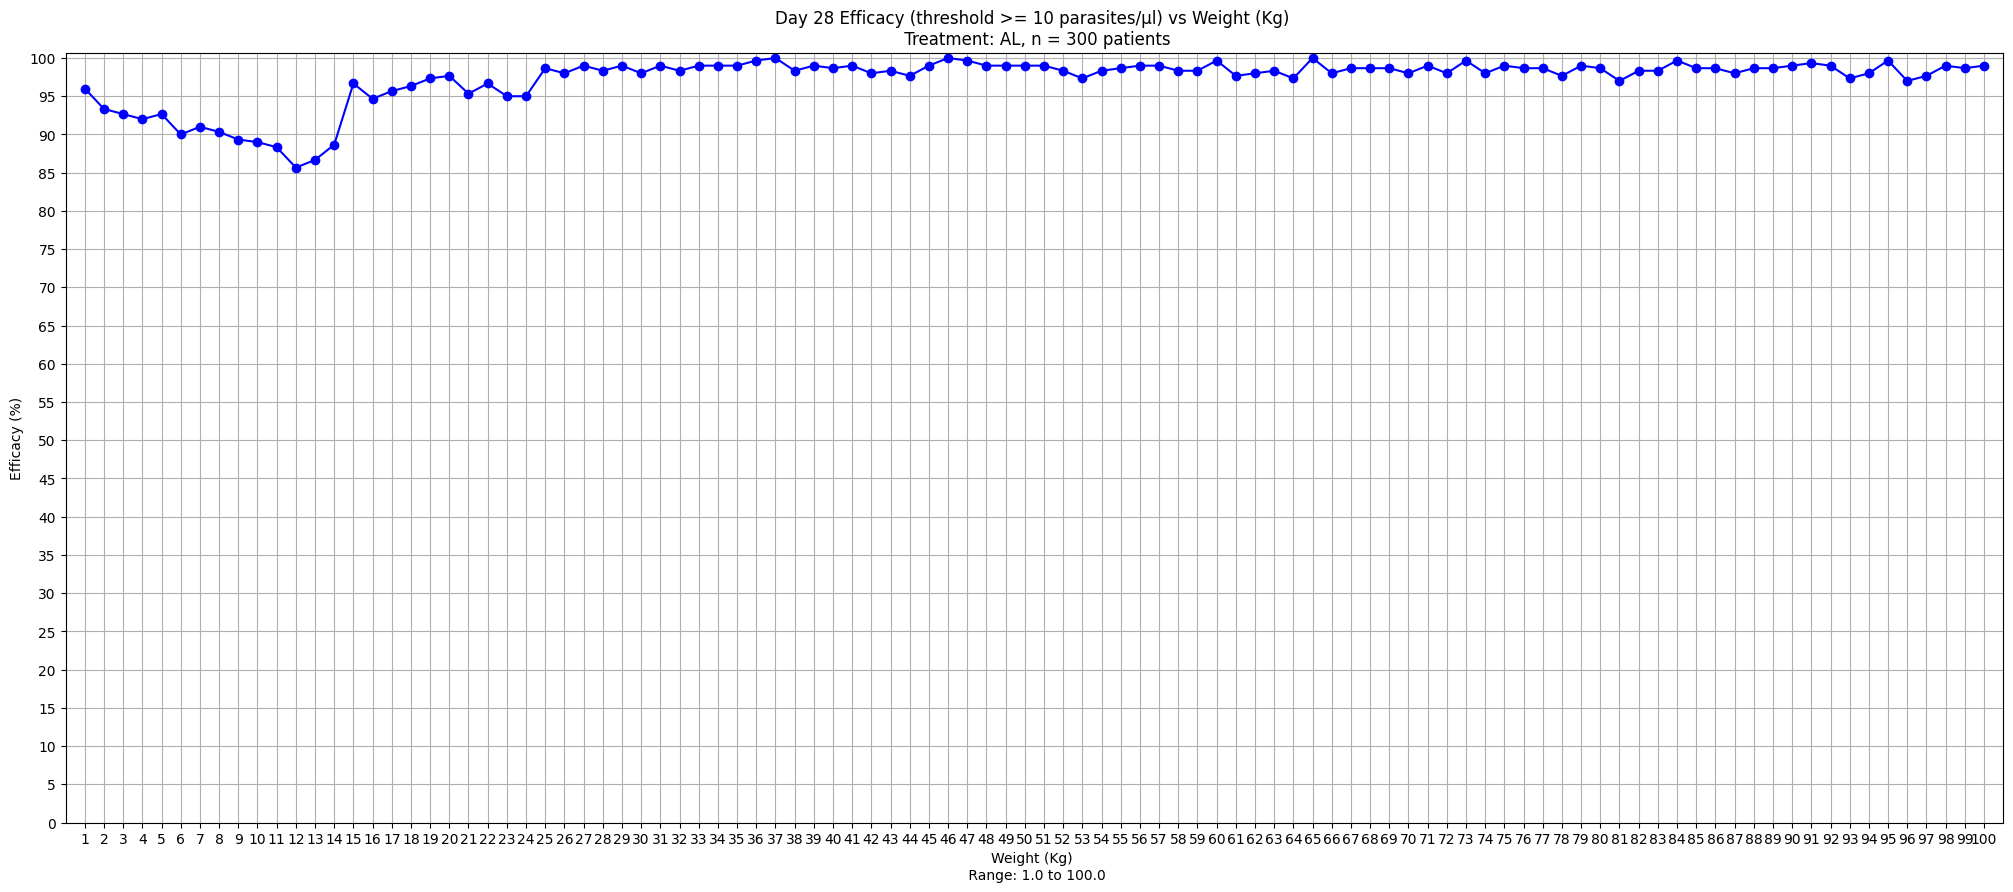

In [17]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'Weight (Kg) \n Range: {min(weight_values)} to {max(weight_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs Weight (Kg) \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(0, max(weight_values)+1)  # Set x-axis limits
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 1))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
#plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_weight_vs_efficacy_results_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

# Victory?!? Let's try `ec50_lum` = 0.0144 ng/microl

In [18]:
def run_simulation_art_weight_adj(idx, weight, n_patients):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--ec50_artemether", "0.0028", 
        "--ec50_lum", "0.0144",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame(
            [line.split() for line in lines_weight],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[df_weight['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_weight)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [19]:
test_exponent = 0.5  # Exponent for patient blood volume calculation
file_suffix = f"patient_blood_volume_exponent_{test_exponent}_adjusted_ec50_lum_ng_microliter"

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 300  # Number of patients for each simulation

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i], n_patients) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_art_weight_adj, params_list):
            idx, efficacy, df_weight = result
            results.append((idx, efficacy, df_weight))
            if df_weight is not None:
                dfs.append(df_weight)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_weight in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with weight_values and clearance_rates
df = pd.DataFrame({
    'Weight': weight_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_weight_vs_efficacy_blood_volume_{}.pyobj".format(file_suffix))

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_weight_vs_efficacy_results_blood_volume_{}.pyobj".format(file_suffix))

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_vs_efficacy_results_blood_volume_pmax_ec50_adjusted_unit_changed_lbb{}.csv".format(file_suffix), index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 100/100 [01:29<00:00,  1.11it/s]

DataFrame saved as pickle and CSV files successfully.


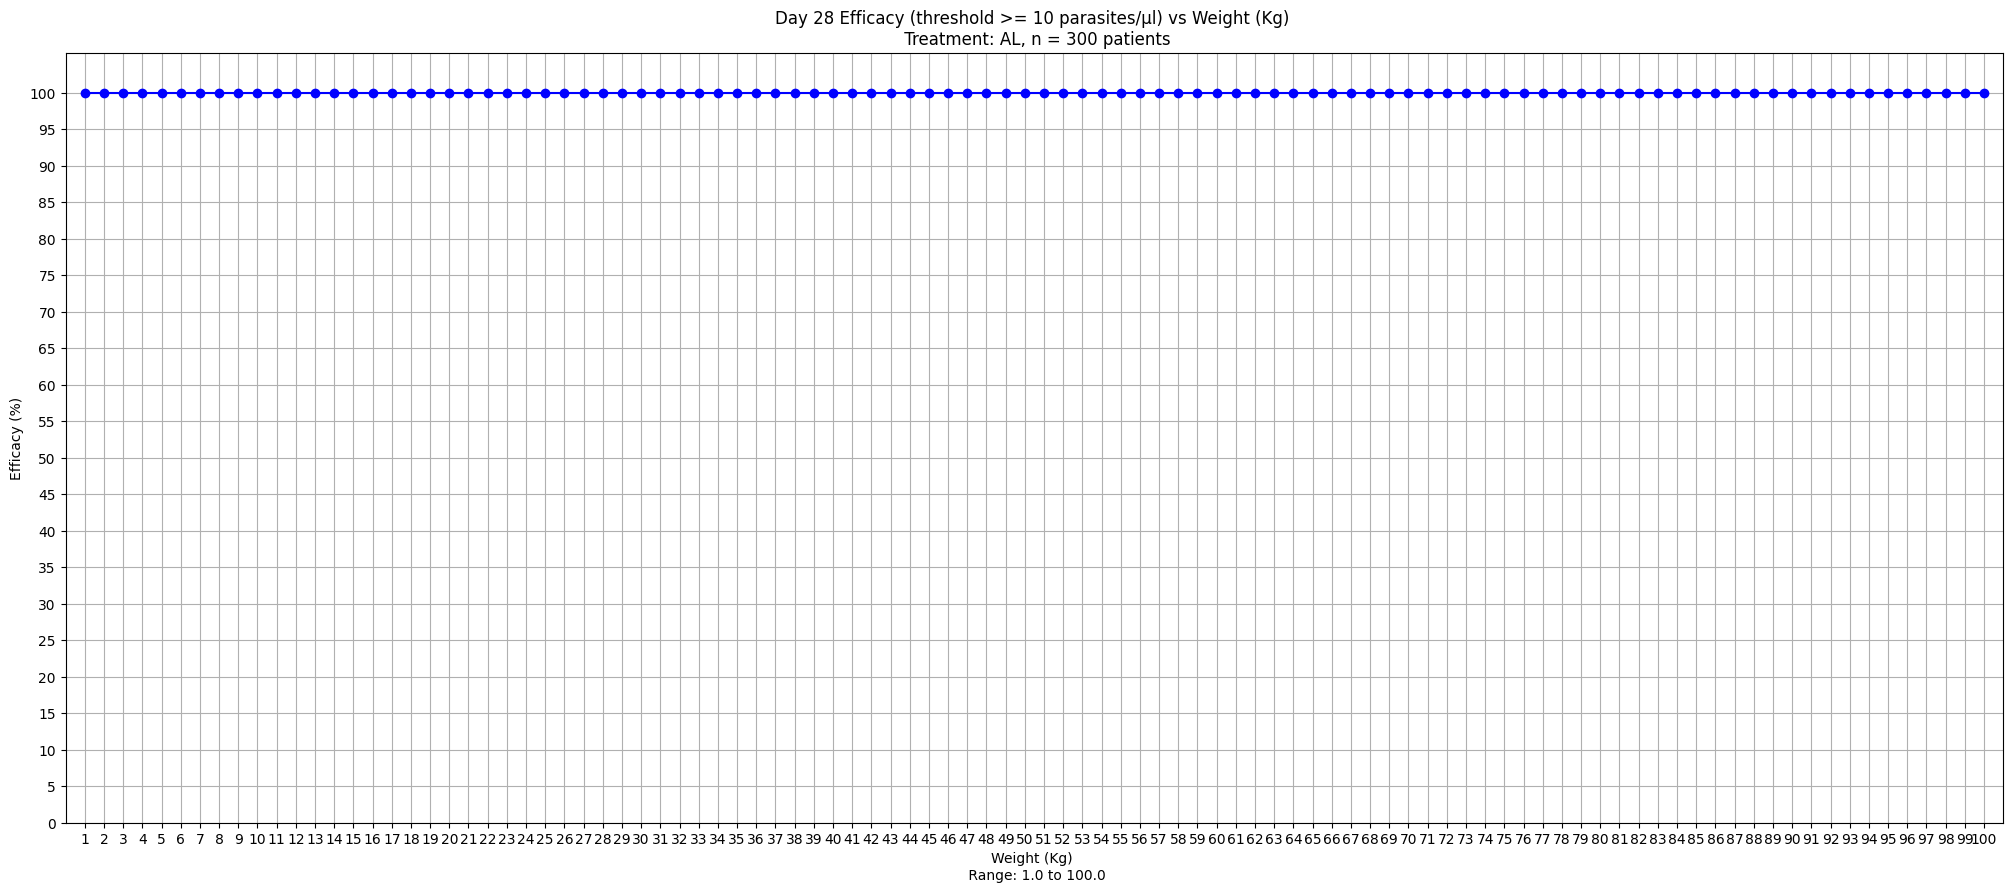

In [20]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'Weight (Kg) \n Range: {min(weight_values)} to {max(weight_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs Weight (Kg) \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(0, max(weight_values)+1)  # Set x-axis limits
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 1))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
#plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_weight_vs_efficacy_results_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()

In [21]:
def run_simulation_art_weight_adj(idx, weight, n_patients):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--ec50_artemether", "0.28", 
        "--ec50_lum", "0.235",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame(
            [line.split() for line in lines_weight],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[df_weight['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_weight)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [22]:
test_exponent = 0.5  # Exponent for patient blood volume calculation
file_suffix = f"patient_blood_volume_exponent_{test_exponent}_adjusted_ec50_art_ng_microliter"

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 300  # Number of patients for each simulation

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i], n_patients) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_art_weight_adj, params_list):
            idx, efficacy, df_weight = result
            results.append((idx, efficacy, df_weight))
            if df_weight is not None:
                dfs.append(df_weight)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_weight in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with weight_values and clearance_rates
df = pd.DataFrame({
    'Weight': weight_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_weight_vs_efficacy_blood_volume_{}.pyobj".format(file_suffix))

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_weight_vs_efficacy_results_blood_volume_{}.pyobj".format(file_suffix))

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_vs_efficacy_results_blood_volume_pmax_ec50_adjusted_unit_changed_lbb{}.csv".format(file_suffix), index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]

DataFrame saved as pickle and CSV files successfully.


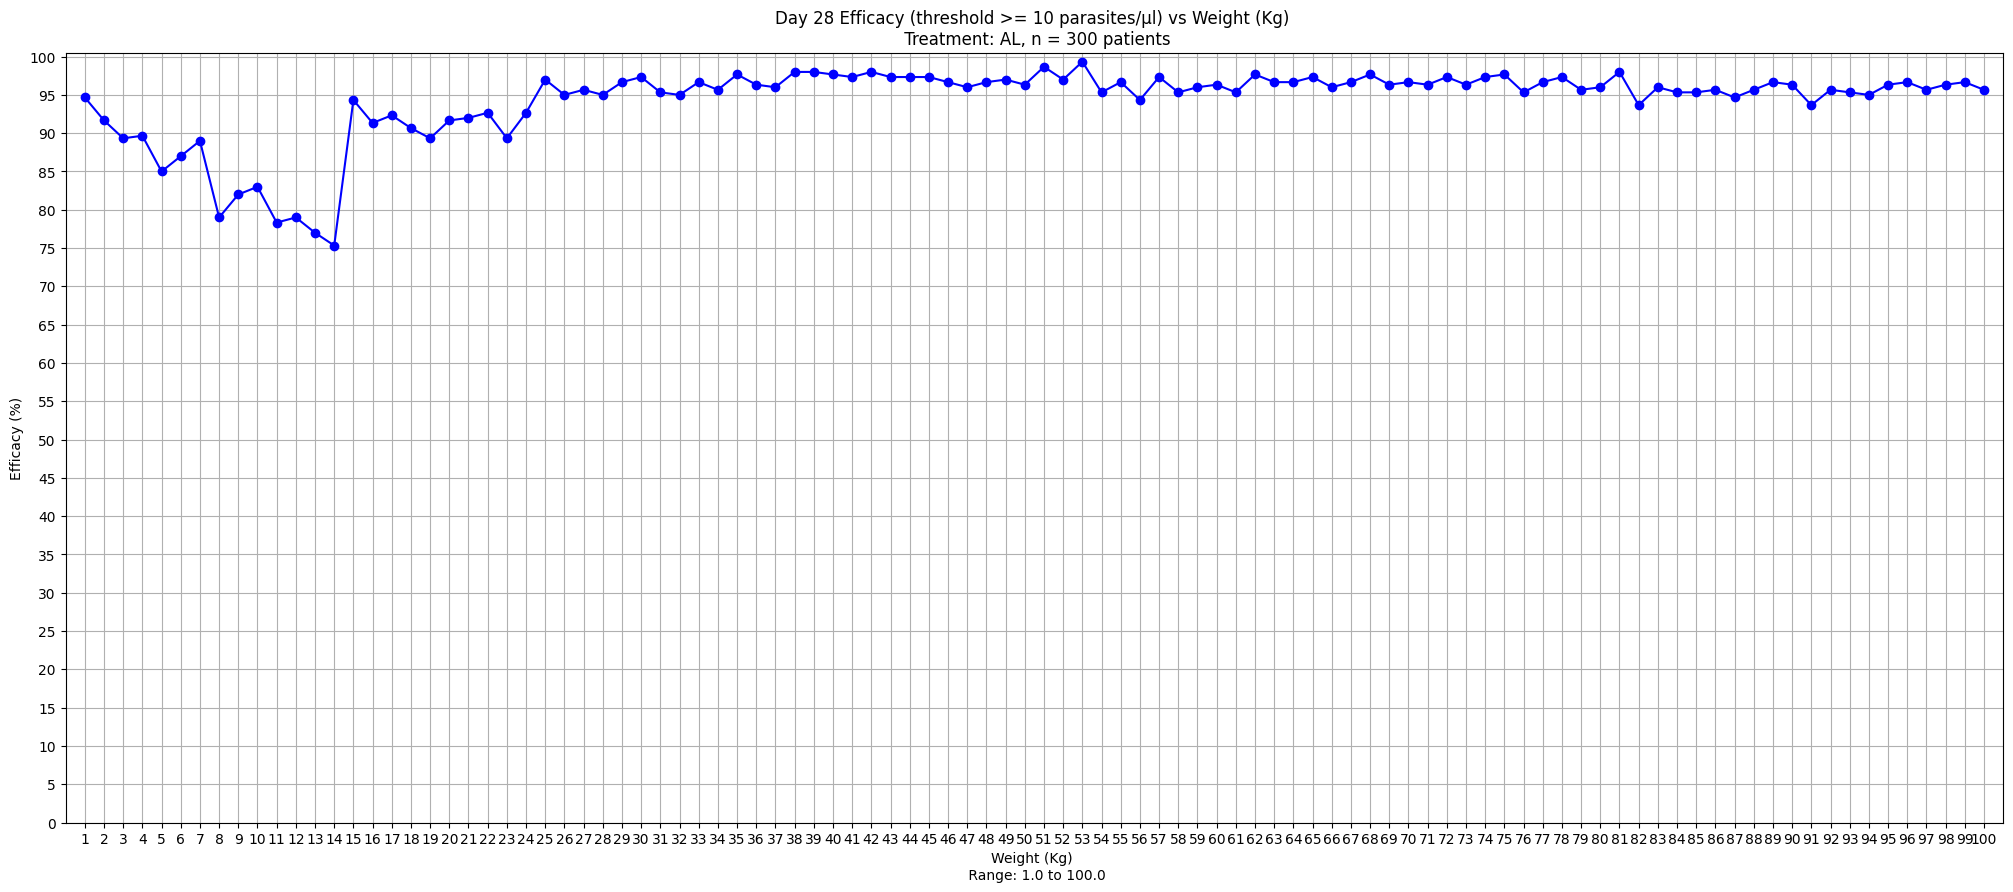

In [23]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'Weight (Kg) \n Range: {min(weight_values)} to {max(weight_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs Weight (Kg) \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(0, max(weight_values)+1)  # Set x-axis limits
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 1))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
#plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_weight_vs_efficacy_results_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()